World Coins: A collection of coin images from 32 different currencies.

In [66]:
# Seznam knihoven
import os
import numpy as np
import random
import cv2
import kaggle
import concurrent.futures
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [67]:
# Stažení dat z Kaggle přes API token
kaggle.api.dataset_download_files('wanderdust/coin-images', path='./data', unzip=True)
print("Dataset byl úspěšně stažen a rozbalen do složky ./data!")

Dataset URL: https://www.kaggle.com/datasets/wanderdust/coin-images
Dataset byl úspěšně stažen a rozbalen do složky ./data!


In [68]:
# Napojení dat a vytvoření cesty
data_dir_train = "data/coins/data/train/"
data_dir_val = "data/coins/data/validation/"
data_dir_test = "data/coins/data/test/"
outlier_dir = "data/coins/data/outliers"
json_path = "data/cat_to_name.json"

Ořezání pravého okraje obrázku o 8 % pro odstranění vodoznaku

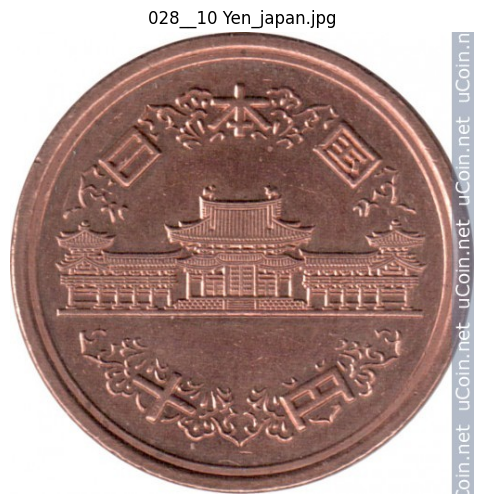

In [70]:
def get_random_image(directory):
    all_folders = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    random_folder = random.choice(all_folders)
    all_images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_images)
random_image_path = get_random_image(data_dir_train)
if random_image_path:
    img = Image.open(random_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(random_image_path)}")
    plt.show()

In [71]:
def crop_images_in_directory(directory, crop_percentage=0.08):
    """ Ořízne pravý okraj všech obrázků v daném adresáři a jeho podsložkách. """
    directory = Path(directory)

    for file_path in directory.rglob('*.[jp][pn]g'):  # Hledá soubory s příponami .jpg, .jpeg, .png
        with Image.open(file_path) as img:
            new_width = int(img.width * (1 - crop_percentage))
            img.crop((0, 0, new_width, img.height)).save(file_path)  # Ořízne a uloží zpět
            print(f"Ořezáno: {file_path}")  # Debug informace

# Spuštění pro test a validation
crop_images_in_directory(data_dir_train)
crop_images_in_directory(data_dir_val)

print("Všechny obrázky byly úspěšně oříznuty.")

Ořezáno: data\coins\data\train\1\001__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\002__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\004__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\005__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\007__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\008__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\009__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\010__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\011__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\012__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\014__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\015__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\016__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\017__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\018__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\019__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\020__1 Cent_australia.j

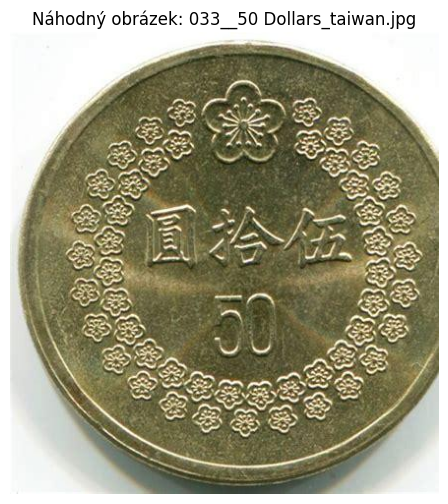

In [72]:
def get_random_image(directory):
    all_folders = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    random_folder = random.choice(all_folders)
    all_images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_images)
random_image_path = get_random_image(data_dir_train)
if random_image_path:
    img = Image.open(random_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Náhodný obrázek: {os.path.basename(random_image_path)}")
    plt.show()

Odstranění pozadí obrázku

In [73]:
# Cesty ke složkám s trénovacími a validačními daty
data_dirs = ["data/coins/data/train/", "data/coins/data/validation/"]

# Funkce pro generování masek
def generate_masks(image_folder):
    """ Pro každý obrázek v dané složce vytvoří binární masku a uloží ji do složky 'masks/' """
    for folder in sorted(os.listdir(image_folder)):  # Procházíme složky 1–211
        folder_path = os.path.join(image_folder, folder)

        if os.path.isdir(folder_path):  # Ověříme, že jde o složku
            mask_folder = os.path.join(folder_path, "masks")  # Vytvoříme složku pro masky
            os.makedirs(mask_folder, exist_ok=True)

            for file in sorted(os.listdir(folder_path)):  # Procházíme obrázky
                file_path = os.path.join(folder_path, file)

                # Ověříme, že soubor je obrázek (JPG, PNG)
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"🎨 Generuji masku pro: {file_path}")
                    
                    # Načtení obrázku jako grayscale
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"❌ Chyba: Nemohu načíst {file_path}")
                        continue

                    # Otsu thresholding pro binární masku
                    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

                    # Uložení masky do složky masks/
                    mask_path = os.path.join(mask_folder, file)
                    cv2.imwrite(mask_path, mask)

# Spuštění generování masek pro složky train a validation
for data_dir in data_dirs:
    print(f"🔄 Generuji masky pro složku: {data_dir}")
    generate_masks(data_dir)

print("✅ Všechny masky byly vygenerovány a uloženy!")

🔄 Generuji masky pro složku: data/coins/data/train/
🎨 Generuji masku pro: data/coins/data/train/1\001__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\002__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\004__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\005__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\007__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\008__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\009__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\010__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\011__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\012__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\014__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\015__1 Cent_australia.jpg
🎨 Generuji masku pro: data/coins/data/train/1\016__1 Cent_australia.jpg
🎨 Generuji m

In [74]:
def build_unet(input_size=(256, 256, 1)):
    """ Vytvoření U-Net architektury """
    inputs = Input(input_size)

    # Encoder (dolní část U-Net)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder (horní část U-Net)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Vytvoření modelu
unet_model = build_unet()

In [75]:
# Velikost obrázku pro U-Net
IMAGE_SIZE = (256, 256)

# Funkce pro načtení obrázků a masek
def load_dataset(data_dirs):
    X, Y = [], []

    for data_dir in data_dirs:
        for folder in sorted(os.listdir(data_dir)):  # Procházíme složky 1–211
            folder_path = os.path.join(data_dir, folder)

            if os.path.isdir(folder_path):
                mask_folder = os.path.join(folder_path, "masks")  # Složka s maskami
                
                for file in sorted(os.listdir(folder_path)):  # Procházíme obrázky
                    file_path = os.path.join(folder_path, file)
                    mask_path = os.path.join(mask_folder, file)

                    # Ověříme, že soubor je obrázek
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        # Načtení obrázku a masky
                        img = load_img(file_path, target_size=IMAGE_SIZE, color_mode="grayscale")
                        mask = load_img(mask_path, target_size=IMAGE_SIZE, color_mode="grayscale")

                        X.append(img_to_array(img) / 255.0)  # Normalizace
                        Y.append(img_to_array(mask) / 255.0)  # Normalizace

    return np.array(X), np.array(Y)

# Načtení trénovacích a validačních dat
print("📂 Načítám dataset...")
X_train, Y_train = load_dataset(["data/coins/data/train/"])
X_val, Y_val = load_dataset(["data/coins/data/validation/"])
print(f"Načteno {len(X_train)} trénovacích a {len(X_val)} validačních obrázků!")


📂 Načítám dataset...
Načteno 6413 trénovacích a 844 validačních obrázků!


In [76]:
# Nastavení cesty pro uložení modelu
save_dir = "preprocessing_model"
os.makedirs(save_dir, exist_ok=True)  # Vytvoří složku, pokud neexistuje
model_path = os.path.join(save_dir, "unet_model.keras")

# Nastavení Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Definujeme callback pro ukládání nejlepšího modelu
checkpoint = ModelCheckpoint("unet_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Dynamické snížení learning rate při stagnaci (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Trénování modelu
print("Začínám trénování...")
history = unet_model.fit(
    X_train, Y_train,
    epochs=50, batch_size=8,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, checkpoint]
)

print("Trénování dokončeno! Model uložen jako 'unet_model.keras'")

Začínám trénování...
Epoch 1/50
 30/802 ━━━━━━━━━━━━━━━━━━━━ 2:24:31 11s/step - accuracy: 0.5611 - loss: 0.8072

KeyboardInterrupt: 

In [ ]:
# VYLEPŠENÝ KÓD

from pathlib import Path
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from concurrent.futures import ThreadPoolExecutor

# 📁 Cesty k modelu a datům
model_path = "preprocessing_model/unet_model.keras"
data_dirs = ["data/coins/data/test/", "data/coins/data/validation/"]

# 📦 Načtení U-Net modelu
model = load_model(model_path)

# 🔹 Funkce pro odstranění pozadí a nahrazení bílým
def remove_background_unet(image_path):
    """ Použití U-Net k odstranění pozadí a nahrazení bílým pozadím """
    image_path = Path(image_path)

    # 🖼️ Načtení obrázku
    img = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    if img is None:
        print(f"⚠️ Nelze načíst {image_path}")
        return

    # 📏 Změna velikosti obrázku
    img_resized = cv2.resize(img, (256, 256)) / 255.0  # Normalizace
    
    # 🔮 Předpověď masky
    input_image = np.expand_dims(img_resized, axis=0)
    predicted_mask = model.predict(input_image, verbose=0)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Prahování masky

    # 🎭 Vrátíme masku na původní velikost
    mask_resized = cv2.resize(predicted_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # 📌 Použití masky k odstranění pozadí
    white_background = np.ones_like(img) * 255  # Bílé pozadí
    img_result = np.where(mask_resized[..., None], img, white_background)  # Pokud maska = 1 → zachováme, jinak bílá

    # 📷 Uložení obrázku jako JPEG
    output_path = image_path.with_suffix(".jpg")  # Přepis do JPG
    cv2.imwrite(str(output_path), img_result, [cv2.IMWRITE_JPEG_QUALITY, 95])
    print(f"✅ Uloženo: {output_path}")

# 🔄 Funkce pro paralelní zpracování obrázků ve složce
def process_images(directory):
    """ Paralelně projde všechny obrázky ve složce a odstraní pozadí """
    directory = Path(directory)
    image_files = list(directory.rglob("*.jpg")) + list(directory.rglob("*.png"))

    with ThreadPoolExecutor() as executor:
        executor.map(remove_background_unet, image_files)

# 🚀 Spuštění procesu pro test a validation
for data_dir in data_dirs:
    process_images(data_dir)

print("Všechny obrázky byly úspěšně zpracovány s bílým pozadím!")


In [ ]:
# Načtení trénovaného U-Net modelu (nahraďte 'unet_model.keras' svou cestou k modelu)
model_path = "preprocessing_model/unet_model.keras"
model = load_model(model_path)

# Cesty k datovým složkám
data_dirs = ["data/coins/data/test/", "data/coins/data/validation/"]

# Funkce pro odstranění pozadí pomocí U-Net
def remove_background_unet(image_path):
    """ Použití U-Net k odstranění pozadí z obrázku """
    
    # Načtení obrázku a změna velikosti podle modelu
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256))  # Přizpůsobte rozměry modelu
    img_resized = img_resized / 255.0  # Normalizace
    
    # Předpověď masky U-Net modelem
    input_image = np.expand_dims(img_resized, axis=0)
    predicted_mask = model.predict(input_image)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Prahování masky
    
    # Vrátíme masku na původní velikost
    mask_resized = cv2.resize(predicted_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Použití masky k odstranění pozadí
    img_result = img * mask_resized[:, :, np.newaxis]
    
    # Konverze do formátu Pillow a přidání bílého pozadí
    pil_img = Image.fromarray(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    white_background = Image.new("RGB", pil_img.size, (255, 255, 255))  # Bílé pozadí
    white_background.paste(pil_img, mask=pil_img.split()[0])  # Aplikace masky

    # Přepsání původního souboru jako JPG
    white_background.save(image_path, "JPEG", quality=95)

# Funkce pro zpracování všech obrázků v adresáři
def process_images(directory):
    """ Projde všechny složky a odstraní pozadí. """
    for folder in os.listdir(directory):  # Procházíme složky 1–211
        folder_path = os.path.join(directory, folder)

        if os.path.isdir(folder_path):  # Ověříme, že jde o složku
            for file in os.listdir(folder_path):  # Procházíme soubory
                file_path = os.path.join(folder_path, file)
                
                # Ověříme, že soubor je obrázek (např. JPG, PNG)
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"🛠️ Odstraňuji pozadí U-Netem: {file_path}")
                    remove_background_unet(file_path)

# Spuštění procesu pro test a validation
for data_dir in data_dirs:
    process_images(data_dir)

print("Všechny obrázky byly zpracovány pomocí U-Net!")

Automatické odstranění outliers přes clustering

In [ ]:
outlier_dir = "data/coins/data/outliers"

# Rychlejší model pro extrakci příznaků
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_extractor.predict(img_array).flatten()

def cluster_and_clean_dataset(root_dir, max_images=500):
    os.makedirs(outlier_dir, exist_ok=True)
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        outlier_category_path = os.path.join(outlier_dir, category)
        os.makedirs(outlier_category_path, exist_ok=True)
        
        if os.path.isdir(category_path):
            image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.png'))]
            if len(image_files) < 2:
                continue
            
            # Omezit počet obrázků pro rychlejší testování
            image_files = image_files[:max_images] if len(image_files) > max_images else image_files
            
            # Extrakce příznaků paralelně
            with concurrent.futures.ThreadPoolExecutor() as executor:
                features = list(executor.map(extract_features, image_files))
            
            # Rychlejší clustering s MiniBatchKMeans
            kmeans = MiniBatchKMeans(n_clusters=2, batch_size=32, random_state=42).fit(features)
            distances = np.min(kmeans.transform(features), axis=1)
            threshold = np.percentile(distances, 90)
            outlier_images = [image_files[i] for i in range(len(image_files)) if distances[i] > threshold]
            
            for img_path in outlier_images:
                os.rename(img_path, os.path.join(outlier_category_path, os.path.basename(img_path)))

# Aplikace clusteringu pro odstranění špatně zařazených obrázků
cluster_and_clean_dataset(data_dir_train)
cluster_and_clean_dataset(data_dir_val)

In [ ]:
# VYLEPŠENÝ KÓD

from pathlib import Path
import numpy as np
import shutil
import concurrent.futures
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import zscore

# 📌 Nastavení
IMG_SIZE = (224, 224)  # Velikost obrázků pro MobileNetV2
N_CLUSTERS = 2         # Počet clusterů pro KMeans
BATCH_SIZE = 32        # Velikost dávky pro MiniBatchKMeans

# 📦 Cesty k datům
OUTLIER_DIR = Path("data/coins/data/outliers")
OUTLIER_DIR.mkdir(parents=True, exist_ok=True)  # Vytvoření složky pro outliery

# 🔍 Rychlejší model pro extrakci příznaků
feature_extractor = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

# 🔹 Funkce pro extrakci příznaků
def extract_features(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_extractor.predict(img_array, verbose=0).flatten()

# 🔄 Hlavní funkce pro clustering
def cluster_and_clean_dataset(root_dir, max_images=500):
    root_dir = Path(root_dir)
    
    for category_path in root_dir.iterdir():  # Prochází kategorie (složky)
        if not category_path.is_dir():
            continue
        
        outlier_category_path = OUTLIER_DIR / category_path.name
        outlier_category_path.mkdir(parents=True, exist_ok=True)

        # 📂 Seznam obrázků
        image_files = list(category_path.glob("*.jpg")) + list(category_path.glob("*.png"))
        if len(image_files) < 2:
            continue

        # 📉 Omezit počet obrázků pro rychlejší testování
        image_files = image_files[:max_images] if len(image_files) > max_images else image_files

        # ⚡ Paralelní extrakce příznaků
        with concurrent.futures.ThreadPoolExecutor() as executor:
            features = np.array(list(executor.map(extract_features, image_files)))

        # 📊 Clustering pomocí MiniBatchKMeans
        kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=BATCH_SIZE, random_state=42).fit(features)
        
        # 📉 Výpočet vzdáleností a detekce outlierů
        distances = np.min(kmeans.transform(features), axis=1)  # Nejkratší vzdálenost ke clustru
        z_scores = zscore(distances)  # Standardizace vzdáleností (z-score)
        outlier_images = [image_files[i] for i in range(len(image_files)) if z_scores[i] > 2.0]  # 2 sigma jako práh

        # 🗑️ Přesun outlierů
        for img_path in outlier_images:
            shutil.move(str(img_path), str(outlier_category_path / img_path.name))

        print(f"📦 Kategorie {category_path.name}: {len(outlier_images)} outlierů přesunuto.")

# 🚀 Spuštění clusteringu
cluster_and_clean_dataset("data/coins/data/train")
cluster_and_clean_dataset("data/coins/data/validation")
